In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import tqdm
try:
    from tqdm import tqdm as iter_progress
except:
    iter_progress=lambda x:x
iter_progress=lambda x:x
from contextlib import ExitStack

Text(0.5, 1.0, 'Fashion MNIST samples')

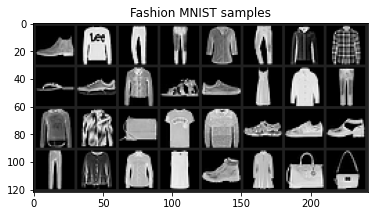

In [2]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=5)

testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=5)

images, labels = next(iter(testloader))
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()*.3+.13
plt.imshow(img.transpose(1,2,0))
plt.title("Fashion MNIST samples")

In [3]:
class MixedPooling(torch.nn.Module):
    def __init__(self, sz):
        super().__init__()
        self.mp = torch.nn.MaxPool2d(sz)
        self.ap = torch.nn.AvgPool2d(sz)
        
    def forward(self, X):
        coeffs=torch.softmax(self.prob_logits, dim=0)
        return .5 * self.mp(X) + .5 * self.ap(X)


class TunedMixedPooling(torch.nn.Module):
    def __init__(self, sz):
        super().__init__()
        self.prob_logits = torch.nn.Parameter(torch.ones(2))
        self.mp = torch.nn.MaxPool2d(sz)
        self.ap = torch.nn.AvgPool2d(sz)
        
    def forward(self, X):
        coeffs=torch.softmax(self.prob_logits, dim=0)
        return coeffs[0] * self.mp(X) + coeffs[1] * self.ap(X)

In [4]:
class VGG11(torch.nn.Module):
    def __init__(self, input_channels=1, output_classes=10, classifier_capacity=1024, pool="max"):
        super().__init__()
        conv2d=torch.nn.Conv2d
        self.relu = torch.nn.ReLU()
        if pool == "max":
            self.pool2d = torch.nn.MaxPool2d(2)
        elif pool == "avg":
            self.pool2d = torch.nn.AvgPool2d(2)
        elif pool == "mixed":
            self.pool2d = MixedPooling(2)
        elif pool == "mixed_tuned":
            self.pool2d = TunedMixedPooling(2)
        else:
            self.pool2d = MixedPooling(2)
        self.avg_pool2d = torch.nn.AdaptiveAvgPool2d((1,1))
        self.c1_1 = conv2d(input_channels, 64, 3, padding=1)
        self.c1_2 = conv2d(64, 128, 1)
        self.c2_1 = conv2d(128, 256, 3, padding=1)
        self.c2_2 = conv2d(256, 256, 1)
        self.c3_1 = conv2d(256, 512, 3, padding=1)
        self.c3_2 = conv2d(512, 512, 1)
        self.c4_1 = conv2d(512, 512, 3, padding=1)
        self.c4_2 = conv2d(512, 512, 1)
        self.fc1 = torch.nn.Linear(512,classifier_capacity)
        self.fc2 = torch.nn.Linear(classifier_capacity, classifier_capacity)
        self.fc_class =  torch.nn.Linear(classifier_capacity, output_classes)
        
        
        self.features = torch.nn.Sequential(self.c1_1,
                                            self.c1_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c2_1,
                                            self.c2_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c3_1,
                                            self.c3_2,
                                            self.relu,
                                            self.pool2d,
                                            self.c4_1,
                                            self.c4_2,
                                            self.relu,
                                            self.avg_pool2d)

        self.classifier = torch.nn.Sequential(self.fc1,
                                              self.relu,
                                              self.fc2,
                                              self.relu,
                                              self.fc_class)

    def forward(self, X):
        features = self.features(X)
        features=features.view([features.size(0),-1])
        return self.classifier(features)
        
        

In [5]:
def run_epoch(net,dataloader,criterion,device,optimizer=None):
    with ExitStack() as stack:
        if optimizer is not None:
            net.train(True)
        else:
            net.train(False)
            gs = stack.enter_context(torch.no_grad())

        accumulated_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(iter_progress(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if optimizer:
                optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            if optimizer:
                loss.backward()
                optimizer.step()
            accumulated_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return correct,total,accumulated_loss

### Let's experiment:
We will compare max-pooling which is the standard for the VGG networks with TunedMixedPooling

We will need two networks and two optimisers
We run then concurently since we have the memory.
Otherwise we would run them one after the other.

Epoch: 0 Train Error: 75.97% Validation Error: 38.43% Loss: 1831.6689459085464
Epoch: 1 Train Error: 26.46% Validation Error: 23.11% Loss: 661.3707878887653
Epoch: 2 Train Error: 19.45% Validation Error: 21.79% Loss: 492.6872853934765
Epoch: 3 Train Error: 16.02% Validation Error: 15.57% Loss: 407.0979207903147
Epoch: 4 Train Error: 14.00% Validation Error: 14.65% Loss: 358.93919837474823
Epoch: 5 Train Error: 12.67% Validation Error: 12.65% Loss: 322.5232946649194
Epoch: 6 Train Error: 11.70% Validation Error: 14.68% Loss: 295.77015218138695
Epoch: 7 Train Error: 10.62% Validation Error: 11.12% Loss: 272.33710388094187
Epoch: 8 Train Error: 10.03% Validation Error: 10.47% Loss: 254.81631108373404
Epoch: 9 Train Error: 9.48% Validation Error: 10.34% Loss: 240.58452766388655
Epoch: 10 Train Error: 8.80% Validation Error: 10.63% Loss: 228.3025790527463
Epoch: 11 Train Error: 8.56% Validation Error: 10.14% Loss: 218.4112331867218
Epoch: 12 Train Error: 8.20% Validation Error: 9.46% Loss: 

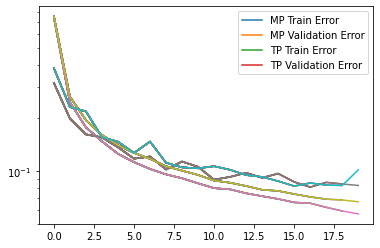

In [6]:
net_mp=VGG11(pool="max").cuda()
net_tp=VGG11(pool="mixed_tuned").cuda()

criterion = torch.nn.CrossEntropyLoss()
mp_optimizer = torch.optim.SGD(net_mp.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)
tp_optimizer = torch.optim.SGD(net_tp.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

mp_train_performance = []
mp_validation_performance = []
mp_times = [0]
tp_train_performance = []
tp_validation_performance = []
tp_times = [0]
t=time.time()

for epoch in range(20):
    train_correct,train_total,train_loss=run_epoch(net_mp, trainloader, criterion, 'cuda', mp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_mp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    mp_train_performance.append(train_err)
    mp_validation_performance.append(test_err)
    mp_times.append(time.time())

    train_correct,train_total,train_loss=run_epoch(net_tp, trainloader, criterion, 'cuda', tp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_tp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    
    tp_train_performance.append(train_err)
    tp_validation_performance.append(test_err)
    tp_times.append(time.time())

    print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
        epoch,100*train_err,100*test_err,train_loss)))
    plt.clf()
    plt.semilogy(range(len(mp_train_performance)),mp_train_performance)
    plt.semilogy(range(len(mp_validation_performance)), mp_validation_performance)
    plt.semilogy(range(len(tp_train_performance)), tp_train_performance)
    plt.semilogy(range(len(tp_validation_performance)), tp_validation_performance)
    plt.legend(["MP Train Error","MP Validation Error", "TP Train Error","TP Validation Error"])

Epoch: 0 Train Error: 3.09% Validation Error: 7.56% Loss: 84.92597348988056
Epoch: 1 Train Error: 2.97% Validation Error: 7.37% Loss: 82.73158972337842
Epoch: 2 Train Error: 2.85% Validation Error: 7.48% Loss: 80.75583989173174
Epoch: 3 Train Error: 2.80% Validation Error: 7.47% Loss: 78.41251845657825
Epoch: 4 Train Error: 2.71% Validation Error: 7.57% Loss: 76.25201227329671
Epoch: 5 Train Error: 2.67% Validation Error: 7.55% Loss: 74.98699735850096
Epoch: 6 Train Error: 2.50% Validation Error: 7.60% Loss: 72.29151499271393
Epoch: 7 Train Error: 2.42% Validation Error: 7.86% Loss: 69.68529358599335
Epoch: 8 Train Error: 2.39% Validation Error: 7.57% Loss: 68.12715217564255
Epoch: 9 Train Error: 2.29% Validation Error: 7.59% Loss: 65.71408436540514
Epoch: 10 Train Error: 2.23% Validation Error: 7.58% Loss: 64.22165075223893
Epoch: 11 Train Error: 2.15% Validation Error: 7.57% Loss: 61.74402684438974


KeyboardInterrupt: 

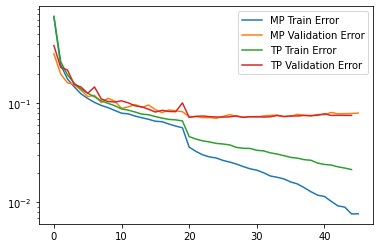

In [11]:
mp_optimizer = torch.optim.SGD(net_mp.parameters(), lr=.001, momentum=0.9, weight_decay=5e-4)
tp_optimizer = torch.optim.SGD(net_tp.parameters(), lr=.001, momentum=0.9, weight_decay=5e-4)

for epoch in range(20):
    train_correct,train_total,train_loss=run_epoch(net_mp, trainloader, criterion, 'cuda', mp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_mp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    mp_train_performance.append(train_err)
    mp_validation_performance.append(test_err)
    mp_times.append(time.time())

    train_correct,train_total,train_loss=run_epoch(net_tp, trainloader, criterion, 'cuda', tp_optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net_tp, testloader, criterion, 'cuda', None)
    test_err=1-float(test_correct)/test_total
    
    tp_train_performance.append(train_err)
    tp_validation_performance.append(test_err)
    tp_times.append(time.time())

    print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
        epoch,100*train_err,100*test_err,train_loss)))
    plt.clf()
    plt.semilogy(range(len(mp_train_performance)),mp_train_performance)
    plt.semilogy(range(len(mp_validation_performance)), mp_validation_performance)
    plt.semilogy(range(len(tp_train_performance)), tp_train_performance)
    plt.semilogy(range(len(tp_validation_performance)), tp_validation_performance)
    plt.legend(["MP Train Error","MP Validation Error", "TP Train Error","TP Validation Error"])

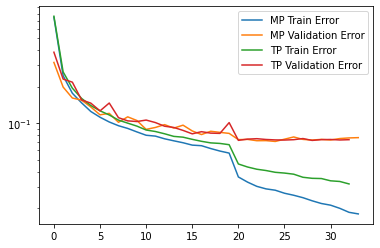

In [10]:
plt.clf()
plt.semilogy(range(len(mp_train_performance)),mp_train_performance)
plt.semilogy(range(len(mp_validation_performance)), mp_validation_performance)
plt.semilogy(range(len(tp_train_performance)), tp_train_performance)
plt.semilogy(range(len(tp_validation_performance)), tp_validation_performance)
plt.legend(["MP Train Error","MP Validation Error", "TP Train Error","TP Validation Error"])